# Introduction to Gaussian Processes
by Seung Min Lee


---

[//]: <> (* a probability distribution describes random variables)
[//]: <> (* a stochastic process governs the properties of functions)


## Linear Regression

### $f(x) = w_0 + w_1 x$
<img src="linear_fn_example.png">
 
### $ f(x) = w_0 + w_1 \phi_1(x) + \ldots + w_{9} \phi_9(x) $
<img src="linear_fn_example3.png">

[//]: <> (### Generalise this to have a random "function")
[//]: <> (<img src="random_fn_example.png">)

## Kernel Regression

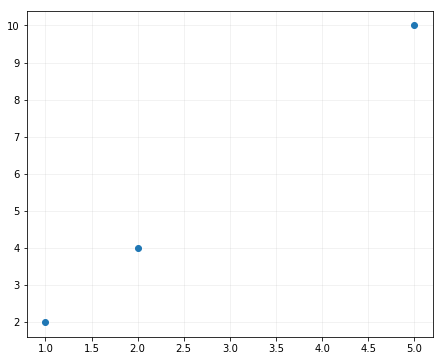

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = [16,6]

x = np.array([1,2,5]); y = x*2
plt.subplot(121)
plt.plot(x, y, 'o')
plt.grid(alpha = 0.2)
plt.show()

Predict $~~f(6)~~$ as 'weighted averging'

i.e. $y = \frac{\sum w_i y_i} {\sum w_i}$

How to measure similarity between points?

A kernel is a similiary function.

e.g. $k(x_i, x_*) = \exp \Big(\frac{-(x_i - x_*)^2}{2\sigma^2} \Big) $

$y_* = \frac{\sum k(x_*, x_i) y_i} {\sum k(x_*, x_i)}$

## Gaussian Process Regression

$
\begin{bmatrix}
 f_1 \\ f_2 \\ f_3
\end{bmatrix}
\sim
N \Bigg(
 \begin{bmatrix}
  0 \\ 0 \\ 0
 \end{bmatrix}
,
K = 
 \begin{bmatrix}
  k_{11} & k_{12} & k_{13} \\
  k_{21} & k_{22} & k_{23} \\
  k_{31} & k_{32} & k_{33}
 \end{bmatrix}
\Bigg)
$

$\textrm{cov}(f(x_p), f(x_q)) = k(x_p, x_q) = \exp \Big( -\frac{1}{2} (x_p-x_q)^2 \Big)$


$
\begin{bmatrix}
 \mathrm{f} \\ \mathrm{f}_*
\end{bmatrix}
\sim
N \Bigg(
 \begin{bmatrix}
  0 \\ 0
 \end{bmatrix}
,
 \begin{bmatrix}
  K(X,X) & K(X,X_*) \\
  K(X_*,X) & K(X_*,X_*)
 \end{bmatrix}
\Bigg)
$

$\mathrm{f}_* ~ \Big| ~ X_*, X, F \sim N \Big(K(X_*,X)K(X,X)^{-1}\mathrm{f}, ~~~
K(X_*, X_*) - K(X_*,X)K(X,X)^{-1}K(X,X_*) \Big)$



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.mlab import bivariate_normal
from numpy.linalg import inv
plt.ion()
#%matplotlib qt5

## First, let's define some kernels. These are just ways to quantify differences between points.
## This specific set of kernels was taken from GP Summer School lecture on Kernel Design [ http://gpss.cc/gpss15/ ]

# linear kernel
def kfunc_linear(x1, x2, l=1):
    #print('kfunc_linear')
    X1, X2 = np.meshgrid(x1, x2)
    return (X1 * X2).T
def kfunc_linear2(x1, x2, l=1):
    #print('kfunc_martern')
    X1, X2 = np.meshgrid(x1, x2)
    return np.abs(X1-X2).T

# exponential kernel
def kfunc_exp(x1, x2, l=1):
    #print('kfunc_exp')
    X1, X2 = np.meshgrid(x1, x2)
    return np.exp(-1 * np.abs(X1-X2)).T

# squared exponential kernel
def kfunc_exp_sq(x1, x2, l=1):
    #print('kfunc_exp_sq')
    X1, X2 = np.meshgrid(x1, x2)
    return np.exp(-0.5 * np.abs((X1-X2)/l)**2).T

# browninan kernel
def kfunc_brown(x1, x2, l=1):
    #print('kfunc_brown')
    X1, X2 = np.meshgrid(x1, x2)
    return np.minimum(X1, X2).T

# matern kernel
def kfunc_matern(x1, x2, l=1):
    #print('kfunc_martern')
    X1, X2 = np.meshgrid(x1, x2)
    return ((1 + np.abs(X1-X2)) * np.exp(-1 * np.abs(X1-X2))).T

# gaussian kernel
def kfunc_gauss(x1, x2, l=1):
    #print('kfunc_gauss')
    X1, X2 = np.meshgrid(x1, x2)
    return np.exp(-0.5 * np.abs((X1-X2)/l)**2).T

# sin kernel
def kfunc_sinc(x1, x2, l=1):
    #print('kfunc_sinc')
    X1, X2 = np.meshgrid(x1, x2)
    Sigma = (np.sin(np.abs(X1-X2))/np.abs(X1-X2)).T
    np.fill_diagonal(Sigma, 1)
    return Sigma

## Function to get the GP solution
def gp_solve(x_train, y_train, x_pred, kernel, sig_noise=0):
    # compute training covariance matrix (used to get relationships in training)
    k_xx = kernel(x_train, x_train)
    # compute covariance between training and testing (used to predict weights into new data), these are redundant
    k_x_xp = kernel(x_train, x_pred)
    k_xp_x = kernel(x_pred, x_train)
    # compute covariance between testing (used to estimate covariance of predictions in new data)
    k_xp_xp = kernel(x_pred, x_pred)

    # compute the prediction without noise = K(xs,x) K(x,x)^{-1} y [eq 2.19]
    # Vinv = solve(k.xx)
    # Mean and covariance functions now include noise [eq 2.22-2.24], which only requires adding an identity/ridge term to the variance component
    Vinv = np.linalg.inv(k_xx + (sig_noise**2)*np.identity(len(k_xx)))

    # compute the estimate and variance for the prediction (note, does not depend on y) [eq 2.19 or 2.23]
    mu = np.dot(np.dot(k_xp_x, Vinv), y_train)
    var = k_xp_xp - np.dot(np.dot(k_xp_x, Vinv), k_x_xp)

    return mu, var

## function to plot the GP solution
def gp_plot(x, y, x_pred, mu_pred, cov_pred, n_sample=0, main=""):

    se_pred = 2*np.sqrt(np.diag(cov_pred))
    # plot samples from the posterior
    # (this can be misleading, we don't actually have the function, we have draws from an MvN using the learned mean and covariance of the function)
    for i in range(n_sample):
        samp_y = np.squeeze(np.random.multivariate_normal(mu_pred, cov_pred, 1))
        plt.plot(x_pred, samp_y, 'red', alpha=0.3)
    # plot the mean
    plt.plot(x_pred, mu_pred, 'red')
    # plot the observations
    plt.plot(x, y, 'o', color='purple', alpha=0.7)
    # plot prediction uncertainty
    plt.fill_between(x_pred, mu_pred-se_pred, mu_pred+se_pred, color = 'pink', alpha=0.7)
    plt.grid(alpha = 0.2)
    plt.title(main)
    #plt.show()


/Users/smlee/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: covariance is not positive-semidefinite.


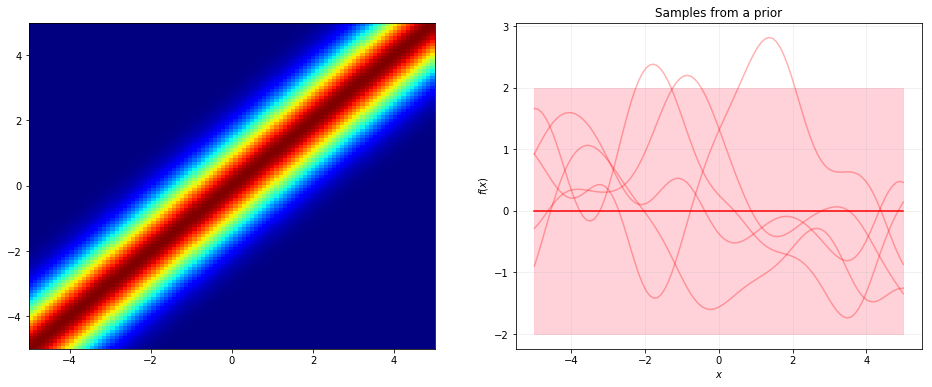

In [31]:
x_test = np.linspace(-5, 5, 100)
# covariance matrix for the inputs
sigma = kfunc_gauss(x_test, x_test)
# plot some samples from the prior sigma
plt.subplot(121)
X1, X2 = np.meshgrid(x_test, x_test)
plt.pcolormesh(X1, X2, sigma, cmap=cm.jet)
plt.subplot(122)
gp_plot(np.nan, np.nan, x_test, np.zeros_like(x_test), sigma, n_sample=5, main="Samples from a prior")
plt.xlabel(r'$x$'); plt.ylabel(r'$f(x)$')

/Users/smlee/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: covariance is not positive-semidefinite.


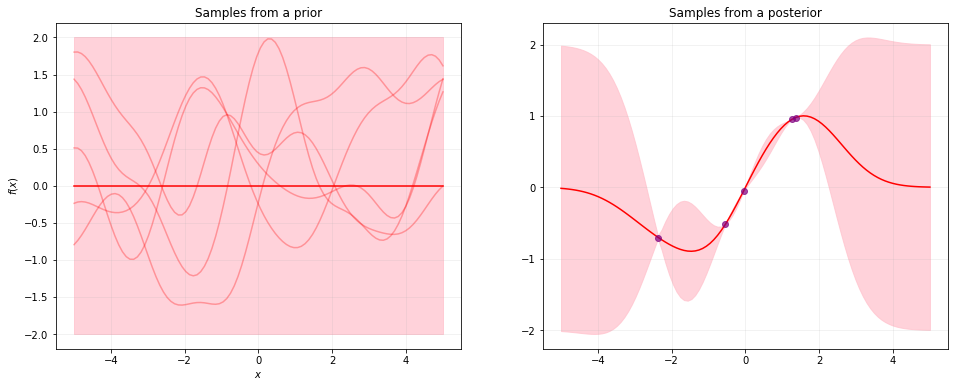

In [30]:

plt.subplot(121)
gp_plot(np.nan, np.nan, x_test, np.zeros_like(x_test), sigma, n_sample=5, main="Samples from a prior")
plt.xlabel(r'$x$'); plt.ylabel(r'$f(x)$')
## Fitting the GP without noise (y = k(x))
# generate some sinusoidal training points
x = np.random.normal(0, 2, 5)
y = np.sin(x)
# solve the GP (without noise) and plot
mu, var = gp_solve(x, y, x_test, kfunc_gauss)
#plt.subplot(121)
#plt.pcolormesh(X1, X2, var, cmap=cm.jet)
plt.subplot(122)
gp_plot(x, y, x_test, mu, var, main="Samples from a posterior" )


/Users/smlee/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: covariance is not positive-semidefinite.
/Users/smlee/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
/Users/smlee/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in sqrt


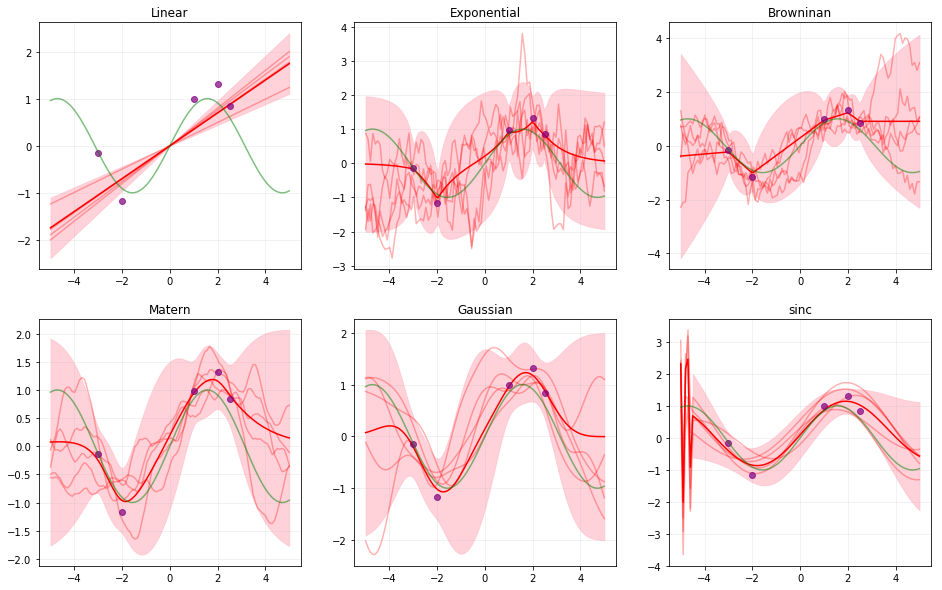

In [35]:
kernels = [kfunc_linear, kfunc_exp, kfunc_brown, kfunc_matern, kfunc_gauss, kfunc_sinc]
kernel_names = ["Linear", "Exponential", "Browninan", "Matern", "Gaussian", "sinc"]

# Plotting a generating sin function with multiple kernels
#x = np.random.normal(0, 2, 5)
x = np.array([-3, -2, 1, 2, 2.5])
y = np.sin(x)
sig_noise = np.sqrt(0.1)
y_noisy = y + np.random.normal(0, sig_noise, len(y))

plt.figure(figsize = (16,10))
for i in range(len(kernels)):
    plt.subplot(2,3,i+1)
    mu, var = gp_solve(x, y_noisy, x_test , kernels[i], sig_noise=sig_noise)
    gp_plot(x , y_noisy, x_test , mu, var, n_sample=5, main=kernel_names[i])
    plt.plot(x_test, np.sin(x_test), 'green', alpha=0.5)
